<a href="https://colab.research.google.com/github/harshvardhansingh3000/GCN-and-GAT-on-Cora/blob/main/Cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cora Dataset

In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric
!pip install ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 750.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

In [4]:
import os
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sp

In [6]:
dataset = Planetoid(root='/tmp/cora', name='Cora')
data=dataset[0]

In [7]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [8]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

threshold 0.011821204285186553


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


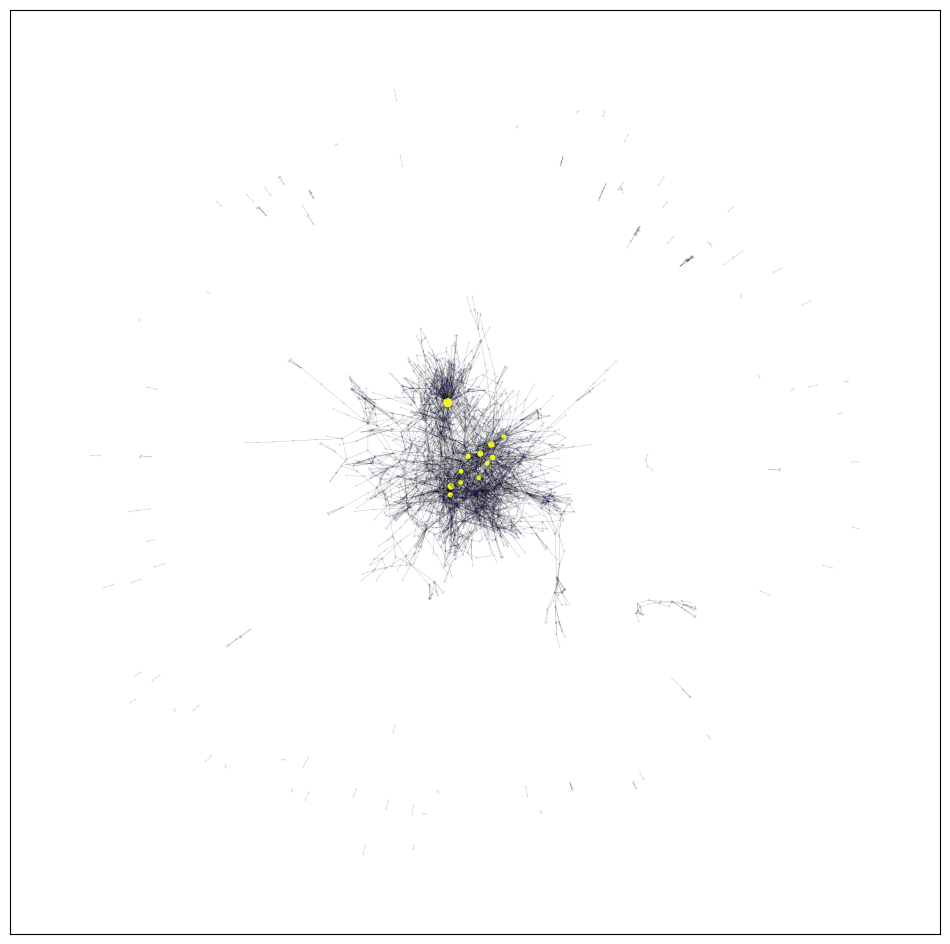

In [12]:
from torch_geometric.utils import to_networkx
import networkx as nx


G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


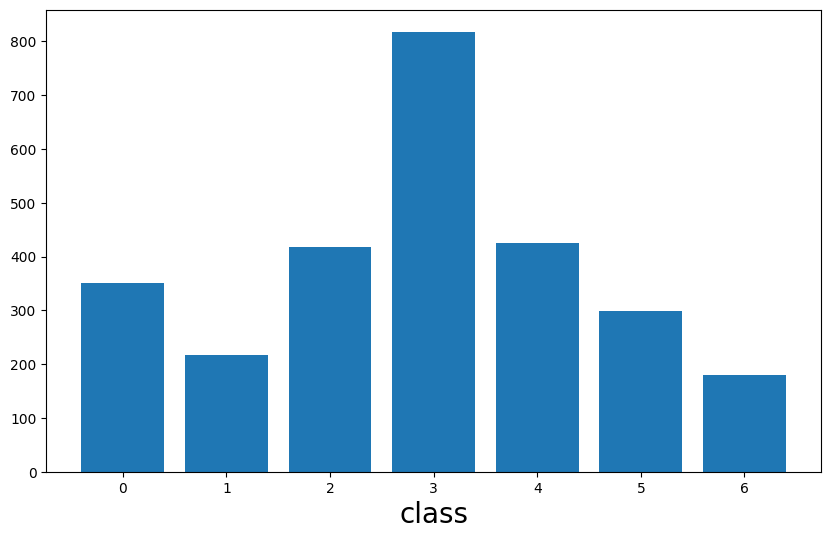

In [13]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

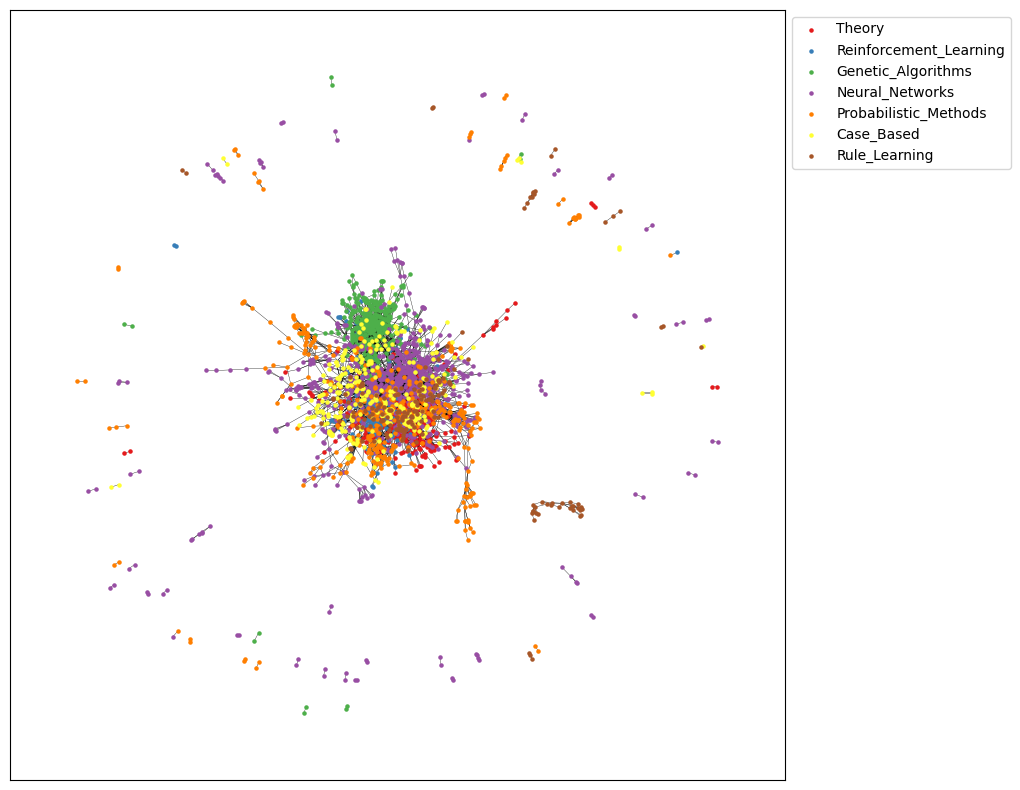

In [14]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


NameError: name 'GCN' is not defined

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return acc

In [ ]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 001, Loss: 1.9480, Accuracy: 0.3140
Epoch: 002, Loss: 1.8421, Accuracy: 0.5130
Epoch: 003, Loss: 1.7031, Accuracy: 0.5740
Epoch: 004, Loss: 1.5353, Accuracy: 0.6100
Epoch: 005, Loss: 1.3997, Accuracy: 0.6110
Epoch: 006, Loss: 1.2339, Accuracy: 0.6320
Epoch: 007, Loss: 1.1258, Accuracy: 0.6550
Epoch: 008, Loss: 0.9998, Accuracy: 0.6900
Epoch: 009, Loss: 0.8998, Accuracy: 0.7110
Epoch: 010, Loss: 0.8069, Accuracy: 0.7260
Epoch: 011, Loss: 0.7017, Accuracy: 0.7390
Epoch: 012, Loss: 0.6465, Accuracy: 0.7510
Epoch: 013, Loss: 0.5436, Accuracy: 0.7560
Epoch: 014, Loss: 0.4973, Accuracy: 0.7620
Epoch: 015, Loss: 0.4372, Accuracy: 0.7670
Epoch: 016, Loss: 0.3715, Accuracy: 0.7750
Epoch: 017, Loss: 0.3254, Accuracy: 0.7750
Epoch: 018, Loss: 0.3309, Accuracy: 0.7780
Epoch: 019, Loss: 0.2835, Accuracy: 0.7770
Epoch: 020, Loss: 0.2683, Accuracy: 0.7760
Epoch: 021, Loss: 0.2397, Accuracy: 0.7770
Epoch: 022, Loss: 0.1998, Accuracy: 0.7770
Epoch: 023, Loss: 0.1961, Accuracy: 0.7790
Epoch: 024,

In [16]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(hidden_channels=8).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [18]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return acc

In [19]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 001, Loss: 2.0407, Accuracy: 0.5830
Epoch: 002, Loss: 1.7954, Accuracy: 0.7480
Epoch: 003, Loss: 1.6351, Accuracy: 0.7940
Epoch: 004, Loss: 1.4850, Accuracy: 0.7960
Epoch: 005, Loss: 1.3968, Accuracy: 0.7950
Epoch: 006, Loss: 1.1911, Accuracy: 0.7930
Epoch: 007, Loss: 1.0764, Accuracy: 0.7850
Epoch: 008, Loss: 1.0844, Accuracy: 0.7830
Epoch: 009, Loss: 0.9369, Accuracy: 0.7820
Epoch: 010, Loss: 0.9670, Accuracy: 0.7870
Epoch: 011, Loss: 0.8232, Accuracy: 0.7930
Epoch: 012, Loss: 0.8013, Accuracy: 0.7950
Epoch: 013, Loss: 0.8549, Accuracy: 0.8020
Epoch: 014, Loss: 0.6813, Accuracy: 0.8140
Epoch: 015, Loss: 0.6176, Accuracy: 0.8130
Epoch: 016, Loss: 0.6594, Accuracy: 0.8170
Epoch: 017, Loss: 0.7164, Accuracy: 0.8210
Epoch: 018, Loss: 0.6169, Accuracy: 0.8190
Epoch: 019, Loss: 0.5769, Accuracy: 0.8190
Epoch: 020, Loss: 0.6218, Accuracy: 0.8180
Epoch: 021, Loss: 0.7119, Accuracy: 0.8200
Epoch: 022, Loss: 0.6191, Accuracy: 0.8190
Epoch: 023, Loss: 0.6569, Accuracy: 0.8140
Epoch: 024,